# HEC-RAS Pipes, Conduits, and Pump Stations HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze the new HEC-RAS Conduits, Pipes, and Pump Stations results using the ras-commander library. It leverages the HdfPipe and HdfPump classes to streamline data extraction, processing, and visualization.

## Package Installation and Environment Setup
Uncomment and run package installation commands if needed

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install ras-commander
# This installs ras-commander and all dependencies

In [2]:
# Import all required modules
#from ras_commander import *  # Import all ras-commander modules

# Import the required libraries for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import sys
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations
import pyproj
from shapely.geometry import Point, LineString, Polygon
import xarray as xr

In [3]:
# This cell will try to import the pip package, if it fails it will 
# add the parent directory to the Python path and try to import again
# This assumes you are working in a subfolder of the ras-commander repository
# This allows a user's revisions to be tested locally without installing the package

import sys
from pathlib import Path

# Flexible imports to allow for development without installation 
#  ** Use this version with Jupyter Notebooks **
try:
    # Try to import from the installed package
    from ras_commander import *
except ImportError:
    # If the import fails, add the parent directory to the Python path
    import os
    current_file = Path(os.getcwd()).resolve()
    rascmdr_directory = current_file.parent
    sys.path.append(str(rascmdr_directory))
    print("Loading ras-commander from local dev copy")
    # Now try to import again
    from ras_commander import *
print("ras_commander imported successfully")


ras_commander imported successfully


# Use Example Project or Load Your Own Project

In [4]:
# Download the Pipes Beta project from HEC and run plan 01

# Define the path to the Pipes Beta project
current_dir = Path.cwd()  # Adjust if your notebook is in a different directory
pipes_ex_path = current_dir / "example_projects" / "Davis"
import logging

# Check if Pipes Beta.p06.hdf exists (so we don't have to re-run the simulation when re-running or debugging)
hdf_file = pipes_ex_path / "DavisStormSystem.p02.hdf"

if not hdf_file.exists():
    # Initialize RasExamples and extract the Pipes Beta project
    RasExamples.extract_project(["Davis"])

    # Initialize the RAS project using the ras. (Pipe Networks are only supported in versions 6.6 and above)
    init_ras_project(pipes_ex_path, "6.6")
    logging.info(f"Pipes Beta project initialized with folder: {ras.project_folder}")
    
    logging.info(f"Pipes Beta object id: {id(ras)}")
    
    # Define the plan number to execute
    plan_number = "02"

    # Update run flags for the project
    RasPlan.update_run_flags(
        plan_number,
        geometry_preprocessor=True,
        unsteady_flow_simulation=True,
        run_sediment=False,
        post_processor=True,
        floodplain_mapping=False
    )

    # Execute Plan 06 using RasCmdr for Pipes Beta
    print(f"Executing Plan {plan_number} for the Pipes Beta Creek project...")
    success_pipes_ex = RasCmdr.compute_plan(plan_number)
    if success_pipes_ex:
        print(f"Plan {plan_number} executed successfully for Pipes Beta.\n")
    else:
        print(f"Plan {plan_number} execution failed for Pipes Beta.\n")
else:
    print("Pipes Beta.p06.hdf already exists. Skipping project extraction and plan execution.")
    # Initialize the RAS project using the ras.
    init_ras_project(pipes_ex_path, "6.6")
    plan_number = "02"

2025-03-27 22:56:45 - ras_commander.RasPrj - INFO - Initializing global 'ras' object via init_ras_project function.
2025-03-27 22:56:45 - ras_commander.RasPrj - INFO - Project initialized. ras_object project folder: c:\GH\ras-commander\examples\example_projects\Davis


Pipes Beta.p06.hdf already exists. Skipping project extraction and plan execution.


###  OPTIONAL: Use your own project instead

your_project_path = Path(r"D:\yourprojectpath")

init_ras_project(your_project_path, "6.6")
plan_number = "01"  # Plan number to use for this notebook 



### If you use this code cell, don't run the previous cell or change to markdown
### NOTE: Ensure the HDF Results file was generated by HEC-RAS Version 6.x or above

# Explore Project Dataframes using 'ras' Object

In [5]:
print("Plan DataFrame for the project:")
ras.plan_df

Plan DataFrame for the project:


,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,1,...,dss,1,PARDISO (Direct),area2,c:\GH\ras-commander\examples\example_projects\...,02,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...


In [6]:
print("\nUnsteady DataFrame for the project:")
ras.unsteady_df


Unsteady DataFrame for the project:


,unsteady_number,full_path,geometry_number,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,01,c:\GH\ras-commander\examples\example_projects\...,None,Full System Rain w/ Pump,6.60,0,Disable,No Wind Forces,Constant,None,-1,in/hr,DSS


In [7]:
print("\nBoundary Conditions DataFrame for the project:")
ras.boundaries_df 


Boundary Conditions DataFrame for the project:


,unsteady_number,boundary_condition_number,river_reach_name,river_station,storage_area_name,pump_station_name,bc_type,hydrograph_type,hydrograph_num_values,Interval,...,Flow Title,Program Version,Use Restart,Precipitation Mode,Wind Mode,Met BC=Precipitation|Mode,Met BC=Evapotranspiration|Mode,Met BC=Precipitation|Expanded View,Met BC=Precipitation|Constant Units,Met BC=Precipitation|Gridded Source
0,01,1,,,,,Normal Depth,None,0,NaN,...,Full System Rain w/ Pump,6.60,0,Disable,No Wind Forces,Constant,None,-1,in/hr,DSS
1,01,2,,,,,Unknown,None,0,1HOUR,...,Full System Rain w/ Pump,6.60,0,Disable,No Wind Forces,Constant,None,-1,in/hr,DSS


In [8]:
# Get HDF Results Entries (only present when results are present)
ras.get_hdf_entries()

,plan_number,unsteady_number,geometry_number,Plan Title,Program Version,Short Identifier,Simulation Date,Computation Interval,Mapping Interval,Run HTab,...,DSS File,Friction Slope Method,UNET D2 SolverType,UNET D2 Name,HDF_Results_Path,Geom File,Geom Path,Flow File,Flow Path,full_path
0,02,01,02,Full System ROM with Pump,6.60,Full System ROM with Pump,"10JAN2000,1200,11JAN2000,2400",12SEC,10MIN,1,...,dss,1,PARDISO (Direct),area2,c:\GH\ras-commander\examples\example_projects\...,02,c:\GH\ras-commander\examples\example_projects\...,01,c:\GH\ras-commander\examples\example_projects\...,c:\GH\ras-commander\examples\example_projects\...


# Find Paths for Results and Geometry HDF's

In [9]:
# Get the plan HDF path for the plan_number defined above
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

In [10]:
plan_hdf_path

'c:\\GH\\ras-commander\\examples\\example_projects\\Davis\\DavisStormSystem.p02.hdf'

In [11]:
# Alternate: Get the geometry HDF path if you are extracting geometry elements from the geometry HDF
geom_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom Path'].values[0] + '.hdf'

In [12]:
geom_hdf_path

'c:\\GH\\ras-commander\\examples\\example_projects\\Davis\\DavisStormSystem.g02.hdf'

In [13]:
# Extract runtime and compute time data
print("\nExtracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data(hdf_path=plan_number)
runtime_df

2025-03-27 22:56:45 - ras_commander.HdfResultsPlan - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:45 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: DavisStormSystem.p02.hdf



Extracting runtime and compute time data


2025-03-27 22:56:45 - ras_commander.HdfResultsPlan - INFO - Plan Name: Full System ROM with Pump
2025-03-27 22:56:45 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 36.0


,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,Full System ROM with Pump,DavisStormSystem.p02.hdf,2000-01-10 12:00:00,2000-01-12,129600.0,36.0,N/A,0.000104,N/A,0.020755,0.022648,1734.498588,1589.579424


-----

# 2D Models with Pipe Networks: HDF Data Extraction Examples

In [14]:
# Get pipe conduits
pipe_conduits_gdf = HdfPipe.get_pipe_conduits("02") # NOTE: Here we use the plan number instead of the path variable.  The library decorators ensure this maps correctly.  
print("\nPipe Conduits: pipe_conduits_gdf")
pipe_conduits_gdf

2025-03-27 22:56:45 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pipe Conduits: pipe_conduits_gdf


,Name,System Name,US Node,DS Node,Modeling Approach,Conduit Length,Max Cell Length,Shape,Rise,Span,...,Slope,US Entrance Loss Coefficient,DS Exit Loss Coefficient,US Backflow Loss Coefficient,DS Backflow Loss Coefficient,DS Flap Gate,Major Group,Minor Group,Polyline,Terrain_Profiles
0,134,Davis,O13-DMH007,O13-DMH006,hydraulic,443.740020,40.0,circular,6.00,6.00,...,0.002723,0.2,0.4,0.2,0.4,0,Major Group 2,,"LINESTRING (6635295.441 1965214.2465, 6635196....","[(0.0, 40.819695), (21.217846, 40.642994), (35..."
1,133,Davis,O13-DMH024,O13-DMH009,hydraulic,800.000024,40.0,circular,6.00,6.00,...,0.001904,0.2,0.4,0.2,0.4,0,Major Group 2,,"LINESTRING (6635597.5485 1964008.2795, 6635403...","[(0.0, 40.530186), (21.1467, 40.44057), (50.88..."
2,132,Davis,O13-DMH006,O13-SDS03,hydraulic,443.740070,40.0,circular,6.00,6.00,...,0.002816,0.2,0.4,0.2,0.4,0,Major Group 2,,"LINESTRING (6635196.5532 1965646.8276, 6635131...","[(0.0, 41.700996), (26.817467, 41.552666), (83..."
3,131,Davis,N13-DMH022,O13-SDS03,hydraulic,982.809915,40.0,circular,6.00,6.00,...,0.002059,0.2,0.4,0.2,0.4,0,Major Group,,"LINESTRING (6634067.2602 1966167.7235, 6634761...","[(0.0, 43.376995), (17.315952, 43.37471), (42...."
4,130,Davis,O13-DMH009,O13-DMH007,hydraulic,443.231808,40.0,circular,6.00,6.00,...,0.000871,0.2,0.4,0.2,0.4,0,Major Group 2,,"LINESTRING (6635403.0525 1964784.2765, 6635295...","[(0.0, 40.699738), (84.2007, 40.623585), (113...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,5,Davis,P13-DI019,P13-DMH014,hydraulic,55.979169,40.0,circular,1.25,1.25,...,0.018086,0.2,0.4,0.2,0.4,0,,,"LINESTRING (6634655.8786 1962994.2229, 6634695...","[(0.0, 42.047863), (35.334522, 42.0), (55.9791..."
128,4,Davis,O14-DI083,O14-DI081,hydraulic,308.809005,40.0,circular,1.25,1.25,...,0.006754,0.2,0.4,0.2,0.4,0,,,"LINESTRING (6637776.3431 1963594.9664, 6637752...","[(0.0, 44.843853), (33.0322, 44.765797), (94.1..."
129,3,Davis,P12-DI011,P12-DMH005,hydraulic,131.688547,40.0,circular,1.25,1.25,...,0.044989,0.2,0.4,0.2,0.4,0,,,"LINESTRING (6631602.9099 1963059.1324, 6631558...","[(0.0, 43.631783), (13.137807, 43.916145), (18..."
130,2,Davis,P12-DI012,P12-DI011,hydraulic,97.998216,40.0,circular,1.25,1.25,...,0.006467,0.2,0.4,0.2,0.4,0,,,"LINESTRING (6631662.213 1962981.1145, 6631602....","[(0.0, 43.573406), (11.616912, 43.510483), (47..."


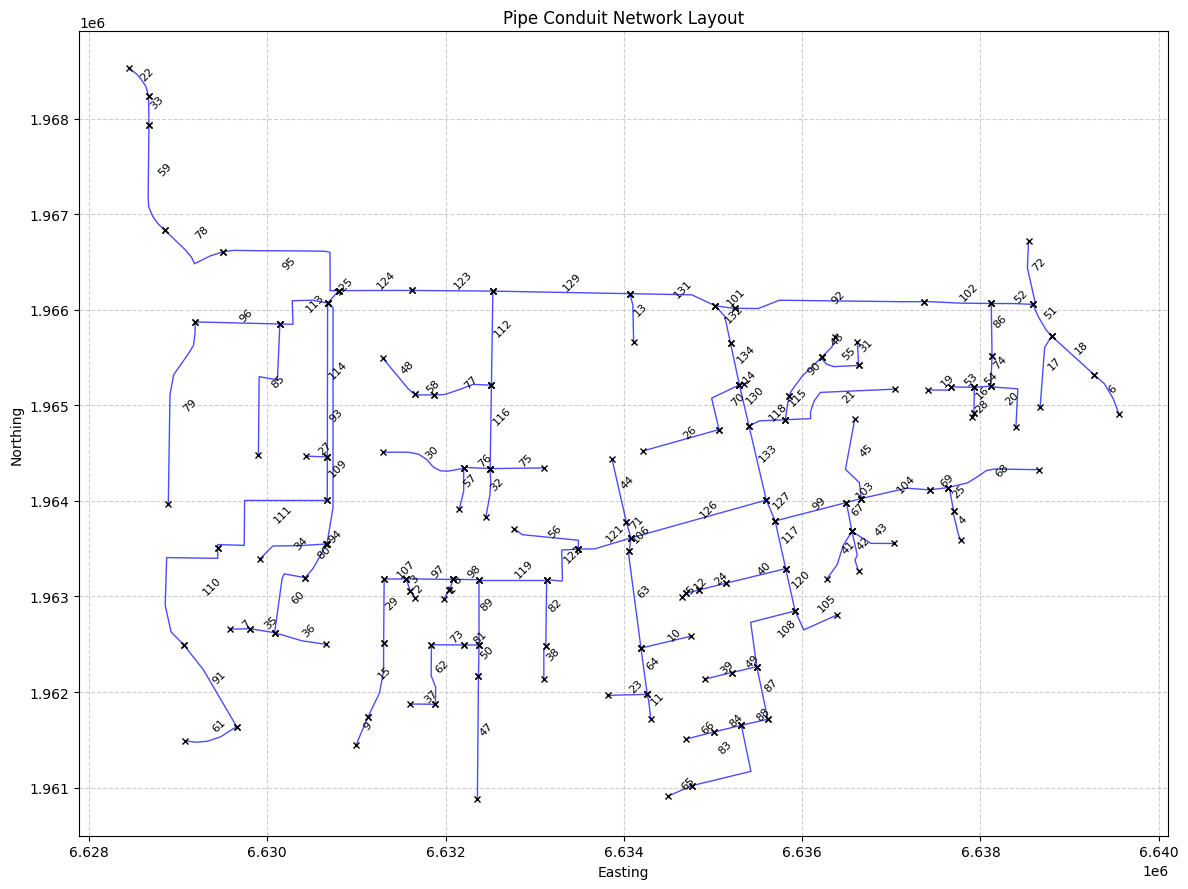

In [15]:
# Plot the pipe conduit linestrings
import matplotlib.pyplot as plt

# Create a new figure with a specified size
plt.figure(figsize=(12, 9))

# Plot each linestring from the GeoDataFrame
for idx, row in pipe_conduits_gdf.iterrows():
    # Extract coordinates from the linestring
    x_coords, y_coords = row['Polyline'].xy
    
    # Plot the linestring
    plt.plot(x_coords, y_coords, 'b-', linewidth=1, alpha=0.7)
    
    # Add vertical line markers at endpoints
    plt.plot([x_coords[0]], [y_coords[0]], 'x', color='black', markersize=4)
    plt.plot([x_coords[-1]], [y_coords[-1]], 'x', color='black', markersize=4)
    
    # Calculate center point of the line
    center_x = (x_coords[0] + x_coords[-1]) / 2
    center_y = (y_coords[0] + y_coords[-1]) / 2
    
    # Add pipe name label at center, oriented top-right
    plt.text(center_x, center_y, f'{row["Name"]}', fontsize=8, 
             verticalalignment='bottom', horizontalalignment='left',
             rotation=45)  # 45 degree angle for top-right orientation

# Add title and labels
plt.title('Pipe Conduit Network Layout')
plt.xlabel('Easting')
plt.ylabel('Northing')

# Add grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()


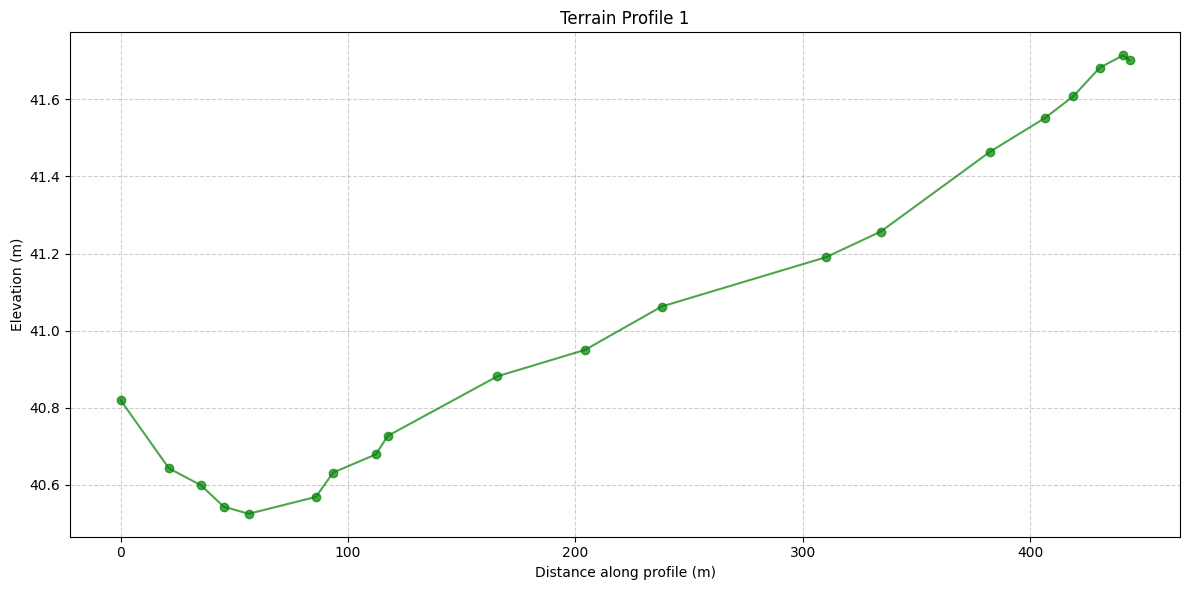

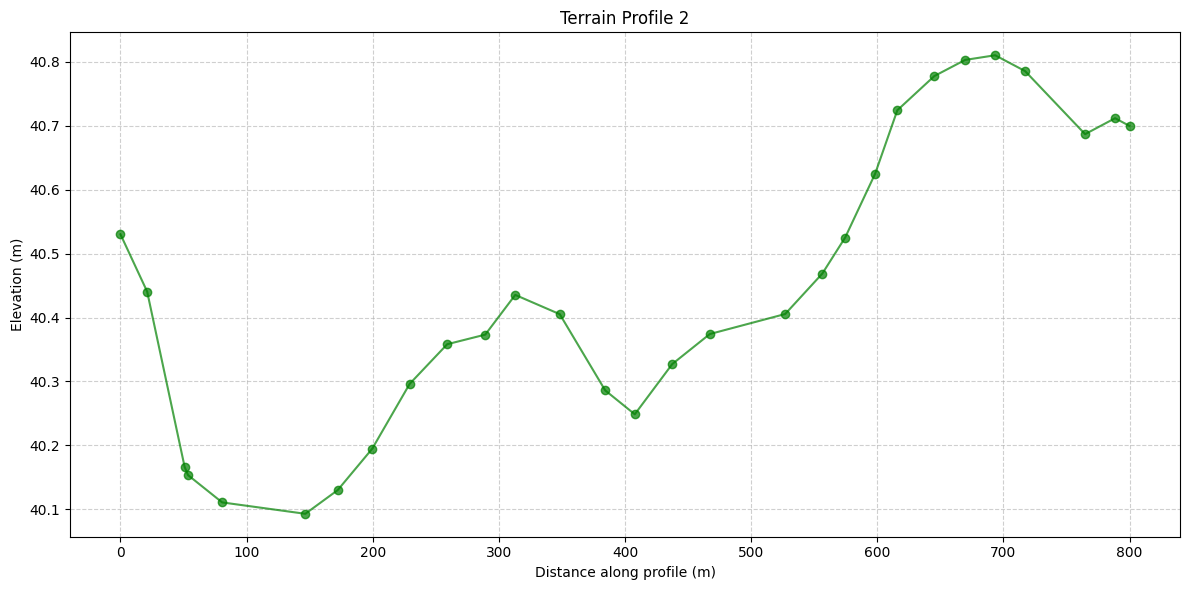

In [16]:
# Plot the first 2 terrain profiles
import matplotlib.pyplot as plt

# Extract terrain profiles from the GeoDataFrame
terrain_profiles = pipe_conduits_gdf['Terrain_Profiles'].tolist()

# Create separate plots for the first 2 terrain profiles
for i in range(2):
    profile = terrain_profiles[i]
    
    # Unzip the profile into x and y coordinates
    x_coords, y_coords = zip(*profile)
    
    # Create a new figure for each profile
    plt.figure(figsize=(12, 6))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='g', alpha=0.7)
    
    # Add title and labels
    plt.title(f'Terrain Profile {i + 1}')
    plt.xlabel('Distance along profile (m)')
    plt.ylabel('Elevation (m)')
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Adjust layout to prevent label clipping
    plt.tight_layout()
    
    # Display the plot
    plt.show()


In [17]:
# Use get_hdf5_dataset_info function to get Pipe Conduits data:
#HdfUtils.get_hdf5_dataset_info(plan_hdf_path, "/Geometry/Pipe Nodes/")

In [18]:
# Get pipe nodes
pipe_nodes_gdf = HdfPipe.get_pipe_nodes(plan_hdf_path)
print("\nPipe Nodes:")
pipe_nodes_gdf

2025-03-27 22:56:47 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pipe Nodes:


,Name,System Name,Node Type,Node Status,Condtui Connections (US:DS),Invert Elevation,Base Area,Terrain Elevation,Terrain Elevation Override,Depth,Drop Inlet Elevation,Drop Inlet Weir Length,Drop Inlet Weir Coefficient,Drop Inlet Orifice Area,Drop Inlet Orifice Coefficient,Total Connection Count,geometry
0,O14-di027,Davis,Junction,Junction with drop inlet,1:1,36.060001,36.0,39.860001,NaN,3.799999,39.863369,3.0,3.3,1.0,0.67,2,POINT (6637926.81 1964917.32)
1,P11-DMH004,Davis,Junction,Junction with drop inlet,1:1,38.169998,36.0,48.720001,NaN,10.550003,48.718811,3.0,3.3,1.0,0.67,2,POINT (6629444.634 1963504.411)
2,O14-DMH005,Davis,Junction,Junction with drop inlet,1:1,31.559999,36.0,40.840000,NaN,9.280001,40.843731,3.0,3.3,1.0,0.67,2,POINT (6637368.497 1966084.574)
3,P11-DMH011,Davis,Junction,Junction with drop inlet,1:1,37.400002,36.0,45.330002,NaN,7.930000,45.332291,3.0,3.3,1.0,0.67,2,POINT (6630653.519 1963548.271)
4,O15-DMH016,Davis,Start,"US Junction, with drop inlet",0:1,38.639999,36.0,41.700001,NaN,3.060001,41.700871,3.0,3.3,1.0,0.67,1,POINT (6638669.136 1964981.664)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,O11-DMH017,Davis,Junction,Junction with drop inlet,3:1,31.410000,36.0,46.750000,NaN,15.340000,46.750332,3.0,3.3,1.0,0.67,4,POINT (6630676.68 1966070.622)
129,N12-DMH010,Davis,Junction,Junction with drop inlet,2:1,31.639999,36.0,46.570000,NaN,14.930000,46.572021,3.0,3.3,1.0,0.67,3,POINT (6630802.812 1966200.091)
130,N12-DMH009,Davis,Junction,Junction with drop inlet,1:1,31.740000,36.0,46.200001,NaN,14.460001,46.197262,3.0,3.3,1.0,0.67,2,POINT (6631619.097 1966201.567)
131,N12-DMH027,Davis,Junction,Junction with drop inlet,2:1,29.709999,36.0,44.830002,NaN,15.120003,44.833260,3.0,3.3,1.0,0.67,3,POINT (6632530.277 1966194.442)


In [19]:
# Use get_hdf5_dataset_info function to get Pipe Conduits data:
#HdfUtils.get_hdf5_dataset_info(plan_hdf_path, "/Geometry/Pipe Networks/")

In [20]:
# Get pipe network data
pipe_network_gdf = HdfPipe.get_pipe_network(plan_hdf_path)
print("\nPipe Network Data:")
pipe_network_gdf

2025-03-27 22:56:47 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - root - INFO - Selected Pipe Network: Davis



Pipe Network Data:


,Cell_ID,Conduit_ID,Node_ID,Minimum_Elevation,DS_Face_Indices,Face_Indices,US_Face_Indices,Cell_Property_Info_Index,US Face Elevation,DS Face Elevation,Min Elevation,Area,Info Index,Cell_Polygon,Face_Polylines,Node_Point
0,0,0,-1,26.824432,[1],"[0, 1]",[0],0,26.934290,26.824432,26.824432,242.040024,0,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
1,1,0,-1,26.714573,[2],"[1, 2]",[1],0,26.934290,26.824432,26.824432,242.040024,0,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
2,2,0,-1,26.604715,[3],"[2, 3]",[2],0,26.934290,26.824432,26.824432,242.040024,0,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
3,3,0,-1,26.494858,[4],"[3, 4]",[3],0,26.934290,26.824432,26.824432,242.040024,0,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
4,4,0,-1,26.385000,[5],"[4, 5]",[4],0,26.934290,26.824432,26.824432,242.040024,0,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1987,1987,-1,72,39.456257,[1976],[1976],[],325,33.416916,33.301682,33.301682,141.037354,28,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
1988,1988,-1,79,42.074768,[1977],[1977],[],326,33.301682,33.186447,33.186447,141.037354,28,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
1989,1989,-1,42,40.804863,[1984],"[1988, 1984]",[1988],327,33.186447,33.071213,33.071213,141.037354,28,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None
1990,1990,-1,46,41.998379,[1987],[1987],[],328,33.071213,32.955978,32.955978,141.037354,28,"POLYGON ((6635288.02154 1965233.24073, 6635279...",[LINESTRING (6635288.021542038 1965233.2407260...,None


In [21]:
# Get pump stations
pump_stations_gdf = HdfPump.get_pump_stations(plan_hdf_path)
print("\nPump Stations:")
pump_stations_gdf

2025-03-27 22:56:47 - ras_commander.HdfPump - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfPump - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Using existing Path object HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pump Stations:


,geometry,station_id,Name,Inlet River,Inlet Reach,Inlet RS,Inlet RS Distance,Inlet SA/2D,Inlet Pipe Node,Outlet River,...,Outlet Pipe Node,Reference River,Reference Reach,Reference RS,Reference RS Distance,Reference SA/2D,Reference Point,Reference Pipe Node,Highest Pump Line Elevation,Pump Groups
0,POINT (6635027.027 1966080.07),0,Pump Station #1,,,,NaN,,Davis [O13-SDS03],,...,,,,,NaN,,,,NaN,1


In [22]:
# Get pump groups
pump_groups_df = HdfPump.get_pump_groups(plan_hdf_path)
print("\nPump Groups:")
pump_groups_df

2025-03-27 22:56:47 - ras_commander.HdfPump - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:47 - ras_commander.HdfPump - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pump Groups:


,Pump Station ID,Name,Bias On,Start Up Time,Shut Down Time,Width,Pumps,efficiency_curve_start,efficiency_curve_count,efficiency_curve
0,0,Pump Station #1,0,5.0,NaN,5.0,1,0,6,"[[2.0, 70.0], [4.0, 60.0], [6.0, 55.0], [8.0, ..."


In [23]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
print(f"Projection: {projection}")

2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Found projection in HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf



Extracting Projection from HDF
Projection: PROJCS["NAD83(HARN) / California zone 2 (ftUS)",GEOGCS["NAD83(HARN)",DATUM["D_North_American_1983_HARN",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["standard_parallel_1",39.83333333333334],PARAMETER["standard_parallel_2",38.33333333333334],PARAMETER["latitude_of_origin",37.66666666666666],PARAMETER["central_meridian",-122],PARAMETER["false_easting",6561666.667],PARAMETER["false_northing",1640416.667],UNIT["Foot_US",0.30480060960121924]]


In [24]:
# Set CRS for GeoDataFrames
if projection:
    pipe_conduits_gdf.set_crs(projection, inplace=True, allow_override=True)
    pipe_nodes_gdf.set_crs(projection, inplace=True, allow_override=True)

print("Pipe Conduits GeoDataFrame columns:")
print(pipe_conduits_gdf.columns)

print("\nPipe Nodes GeoDataFrame columns:")
print(pipe_nodes_gdf.columns)

perimeter_polygons = HdfMesh.get_mesh_areas(geom_hdf_path)
if projection:
    perimeter_polygons.set_crs(projection, inplace=True, allow_override=True)
    
print("\nPerimeter Polygons GeoDataFrame columns:")
print(perimeter_polygons.columns)

Pipe Conduits GeoDataFrame columns:
Index(['Name', 'System Name', 'US Node', 'DS Node', 'Modeling Approach',
       'Conduit Length', 'Max Cell Length', 'Shape', 'Rise', 'Span',
       'Manning's n', 'US Offset', 'DS Offset', 'US Elevation', 'DS Elevation',
       'Slope', 'US Entrance Loss Coefficient', 'DS Exit Loss Coefficient',
       'US Backflow Loss Coefficient', 'DS Backflow Loss Coefficient',
       'DS Flap Gate', 'Major Group', 'Minor Group', 'Polyline',
       'Terrain_Profiles'],
      dtype='object')

Pipe Nodes GeoDataFrame columns:
Index(['Name', 'System Name', 'Node Type', 'Node Status',
       'Condtui Connections (US:DS)', 'Invert Elevation', 'Base Area',
       'Terrain Elevation', 'Terrain Elevation Override', 'Depth',
       'Drop Inlet Elevation', 'Drop Inlet Weir Length',
       'Drop Inlet Weir Coefficient', 'Drop Inlet Orifice Area',
       'Drop Inlet Orifice Coefficient', 'Total Connection Count', 'geometry'],
      dtype='object')


2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Using existing Path object HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Using HDF file from h5py.File object: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfBase - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 2


Perimeter Polygons GeoDataFrame columns:
Index(['mesh_name', 'geometry'], dtype='object')


2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Using existing Path object HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Using existing Path object HDF file: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22:56:47 - ras_commander.HdfMesh - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.g02.hdf
2025-03-27 22

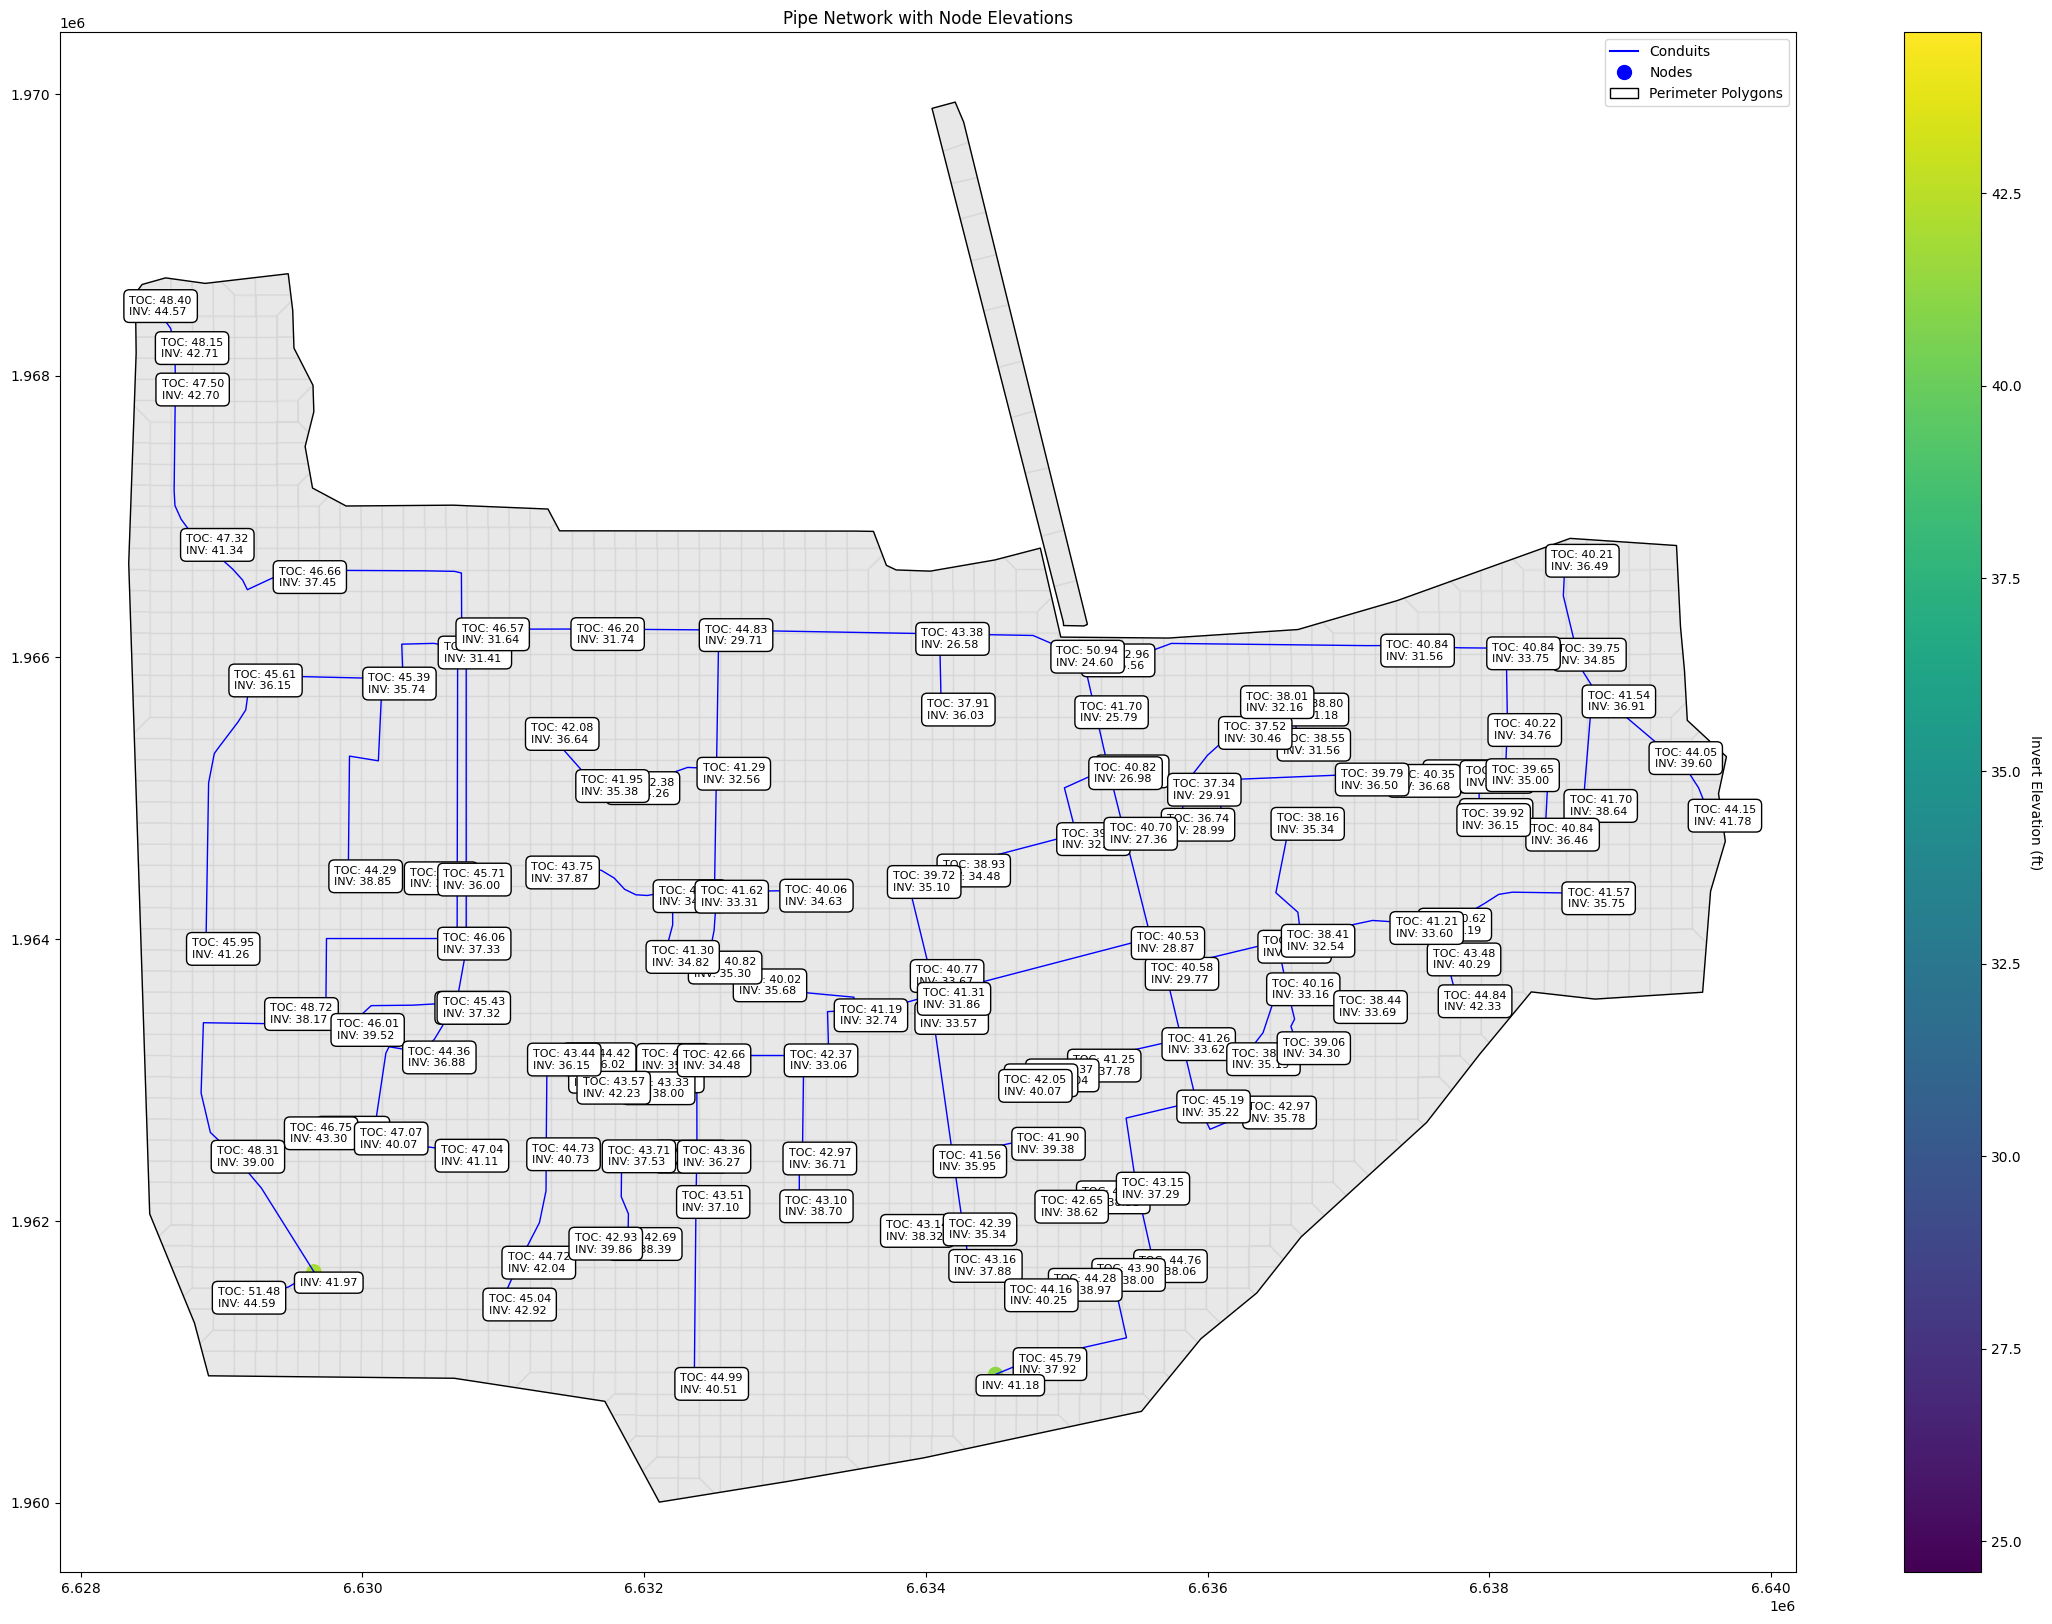

In [25]:
import matplotlib.pyplot as plt
from shapely import wkt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np

fig, ax = plt.subplots(figsize=(28, 20))

# Plot cell polygons with 50% transparency behind the pipe network
cell_polygons_df = HdfMesh.get_mesh_cell_polygons(geom_hdf_path)
if not cell_polygons_df.empty:
    cell_polygons_df.plot(ax=ax, edgecolor='lightgray', facecolor='lightgray', alpha=0.5)

# Plot pipe conduits - the Polyline column already contains LineString geometries
pipe_conduits_gdf.set_geometry('Polyline', inplace=True)

# Plot each pipe conduit individually to ensure all are shown
for idx, row in pipe_conduits_gdf.iterrows():
    ax.plot(*row.Polyline.xy, color='blue', linewidth=1)

# Create a colormap for node elevations
norm = plt.Normalize(pipe_nodes_gdf['Invert Elevation'].min(), 
                    pipe_nodes_gdf['Invert Elevation'].max())
cmap = plt.cm.viridis

# Plot pipe nodes colored by invert elevation
scatter = ax.scatter(pipe_nodes_gdf.geometry.x, pipe_nodes_gdf.geometry.y,
                    c=pipe_nodes_gdf['Invert Elevation'], 
                    cmap=cmap, norm=norm,
                    s=100)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Invert Elevation (ft)', rotation=270, labelpad=15)

# Add combined labels for invert and drop inlet elevations
for idx, row in pipe_nodes_gdf.iterrows():
    label_text = ""  # Initialize label_text for each node
    # Add drop inlet elevation label if it exists and is not NaN
    if 'Drop Inlet Elevation' in row and not np.isnan(row['Drop Inlet Elevation']):
        label_text += f"TOC: {row['Drop Inlet Elevation']:.2f}\n"
    label_text += f"INV: {row['Invert Elevation']:.2f}"
    
    ax.annotate(label_text,
                xy=(row.geometry.x, row.geometry.y),
                xytext=(-10, -10), textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Add perimeter polygons 
if not perimeter_polygons.empty:
    perimeter_polygons.plot(ax=ax, edgecolor='black', facecolor='none')

# Create proxy artists for legend
conduit_line = mlines.Line2D([], [], color='blue', label='Conduits')
node_point = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                          markersize=10, label='Nodes')
perimeter = mpatches.Patch(facecolor='none', edgecolor='black',
                          label='Perimeter Polygons')

ax.set_title('Pipe Network with Node Elevations')

# Add legend with proxy artists
ax.legend(handles=[conduit_line, node_point, perimeter])

# Set aspect ratio to be equal and adjust limits
ax.set_aspect('equal', 'datalim')
ax.autoscale_view()

plt.show()


C:\Users\billk\AppData\Local\Temp\ipykernel_3188\1821049155.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


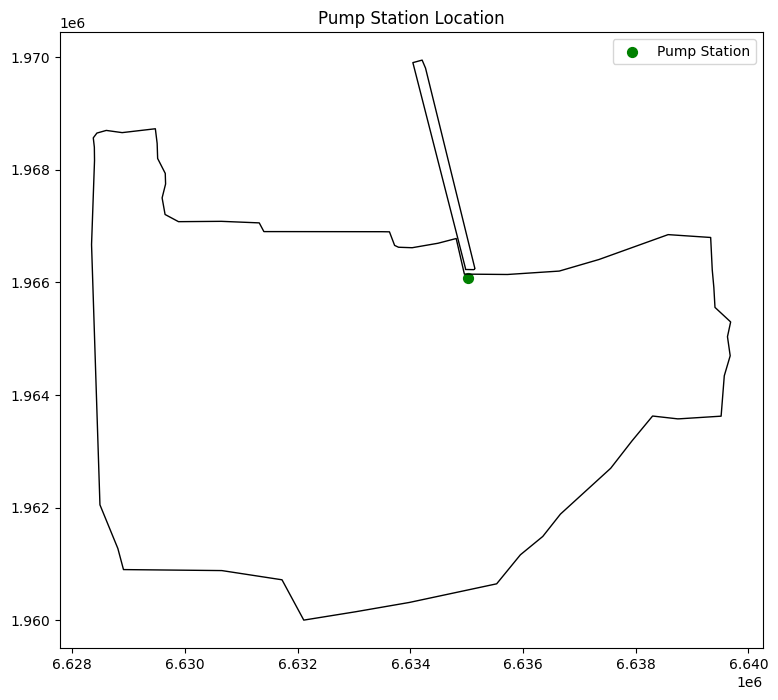

In [26]:
# Visualize pump stations on a map
fig, ax = plt.subplots(figsize=(12, 8))
pump_stations_gdf.plot(ax=ax, color='green', markersize=50, label='Pump Station')

# Add perimeter polygons
if not perimeter_polygons.empty:
    perimeter_polygons.plot(ax=ax, edgecolor='black', facecolor='none', label='Perimeter Polygons')

ax.set_title('Pump Station Location')
ax.legend()
plt.show()

In [27]:
# Example 3: Get pipe network timeseries
valid_variables = [
    "Cell Courant", "Cell Water Surface", "Face Flow", "Face Velocity",
    "Face Water Surface", "Pipes/Pipe Flow DS", "Pipes/Pipe Flow US",
    "Pipes/Vel DS", "Pipes/Vel US", "Nodes/Depth", "Nodes/Drop Inlet Flow",
    "Nodes/Water Surface"
]

print("Valid variables for pipe network timeseries:")
for var in valid_variables:
    print(f"- {var}")

# Extract pipe network timeseries for each valid pipe-related variable
pipe_variables = [var for var in valid_variables if var.startswith("Pipes/") or var.startswith("Nodes/")]

for variable in pipe_variables:
    try:
        pipe_timeseries = HdfPipe.get_pipe_network_timeseries(plan_hdf_path, variable=variable)
        print(f"\nPipe Network Timeseries ({variable}):")
        print(pipe_timeseries.head())  # Print first few rows to avoid overwhelming output
    except Exception as e:
        print(f"Error extracting {variable}: {str(e)}")

2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03

Valid variables for pipe network timeseries:
- Cell Courant
- Cell Water Surface
- Face Flow
- Face Velocity
- Face Water Surface
- Pipes/Pipe Flow DS
- Pipes/Pipe Flow US
- Pipes/Vel DS
- Pipes/Vel US
- Nodes/Depth
- Nodes/Drop Inlet Flow
- Nodes/Water Surface

Pipe Network Timeseries (Pipes/Pipe Flow DS):
<xarray.DataArray 'Pipes/Pipe Flow DS' (time: 5, location: 5)> Size: 100B
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00],
       [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00],
       [-0.0000000e+00, -6.6351867e-03, -0.0000000e+00, -0.0000000e+00,
        -0.0000000e+00],
       [-0.0000000e+00, -1.5214826e-01, -0.0000000e+00, -0.0000000e+00,
         1.2617193e-07]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 40B 2000-01-10T12:00:00 ... 2000-01-10T12...
  * location  (locatio

### Pipe Network Timeseries Data Description

The `get_pipe_network_timeseries` function returns an xarray DataArray for each variable. Here's a general description of the data structure:

1. **Pipes/Pipe Flow DS and Pipes/Pipe Flow US**:
   - Dimensions: time, location (pipe IDs)
   - Units: ft^3/s (cubic feet per second)
   - Description: Represents the flow rate at the downstream (DS) and upstream (US) ends of pipes over time.

2. **Pipes/Vel DS and Pipes/Vel US**:
   - Dimensions: time, location (pipe IDs)
   - Units: ft/s (feet per second)
   - Description: Shows the velocity at the downstream (DS) and upstream (US) ends of pipes over time.

3. **Nodes/Depth**:
   - Dimensions: time, location (node IDs)
   - Units: ft (feet)
   - Description: Indicates the depth of water at each node over time.

4. **Nodes/Drop Inlet Flow**:
   - Dimensions: time, location (node IDs)
   - Units: cfs (cubic feet per second)
   - Description: Represents the flow rate through drop inlets at each node over time.

5. **Nodes/Water Surface**:
   - Dimensions: time, location (node IDs)
   - Units: ft (feet)
   - Description: Shows the water surface elevation at each node over time.

General notes:
- The 'time' dimension represents the simulation timesteps.
- The 'location' dimension represents either pipe IDs or node IDs, depending on the variable.
- The number of timesteps and locations may vary depending on the specific dataset and simulation setup.
- Negative values in flow variables may indicate reverse flow direction.



2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


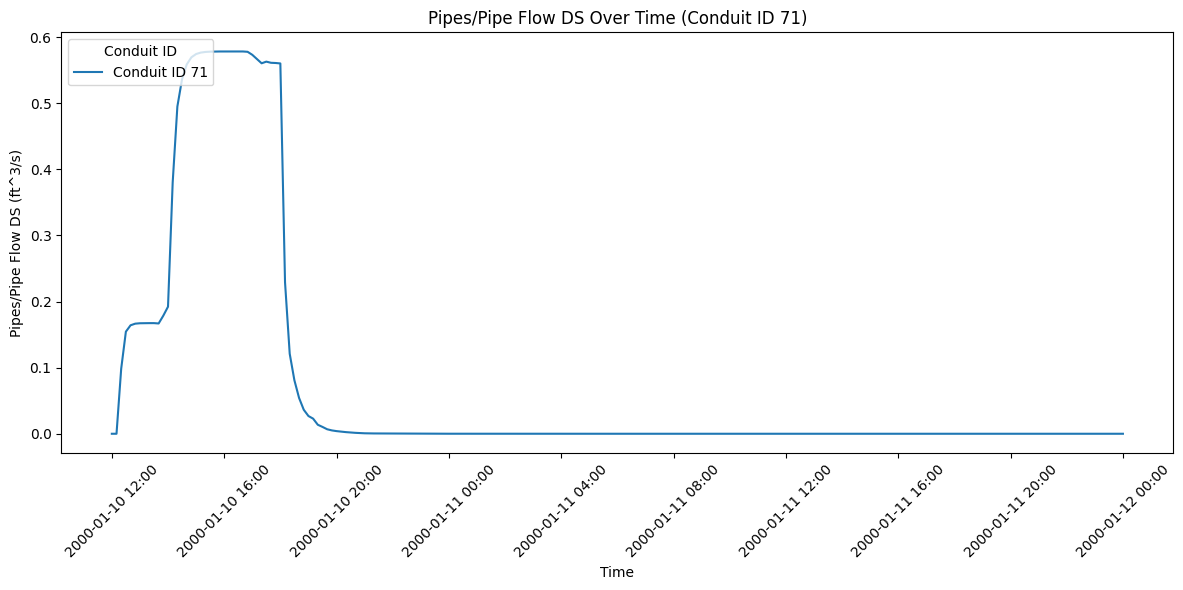

2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:52 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


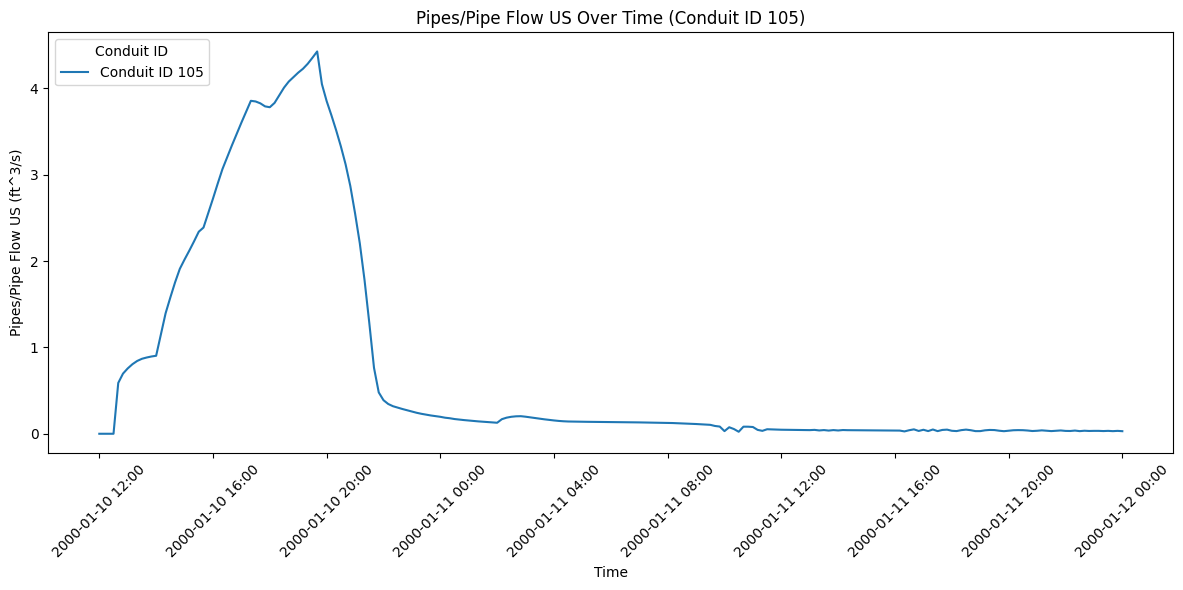

2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


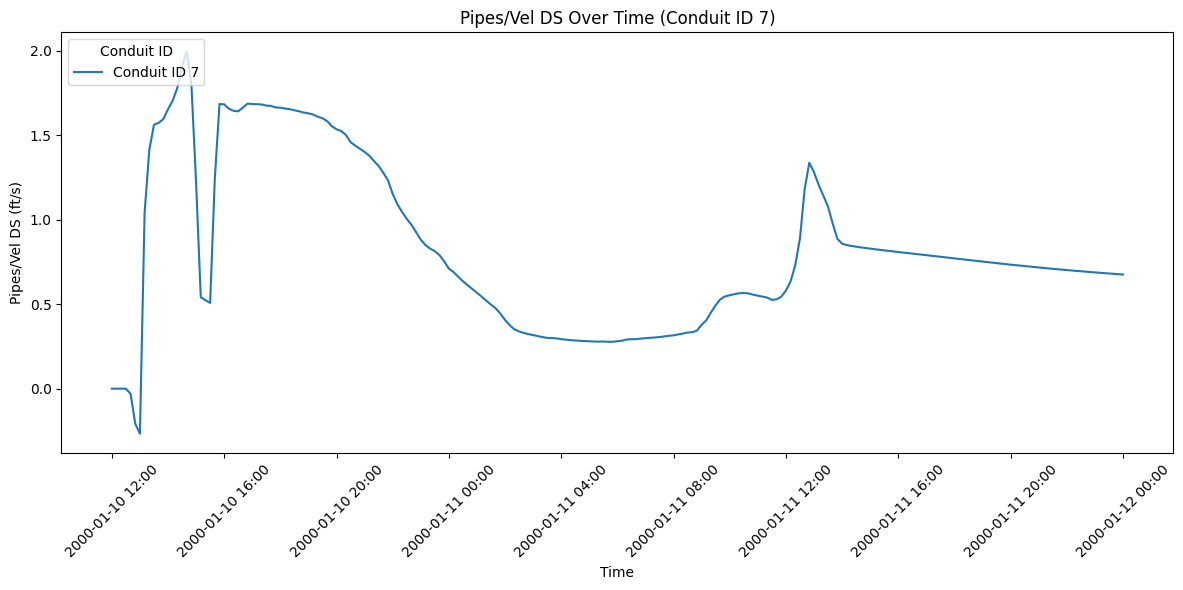

2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


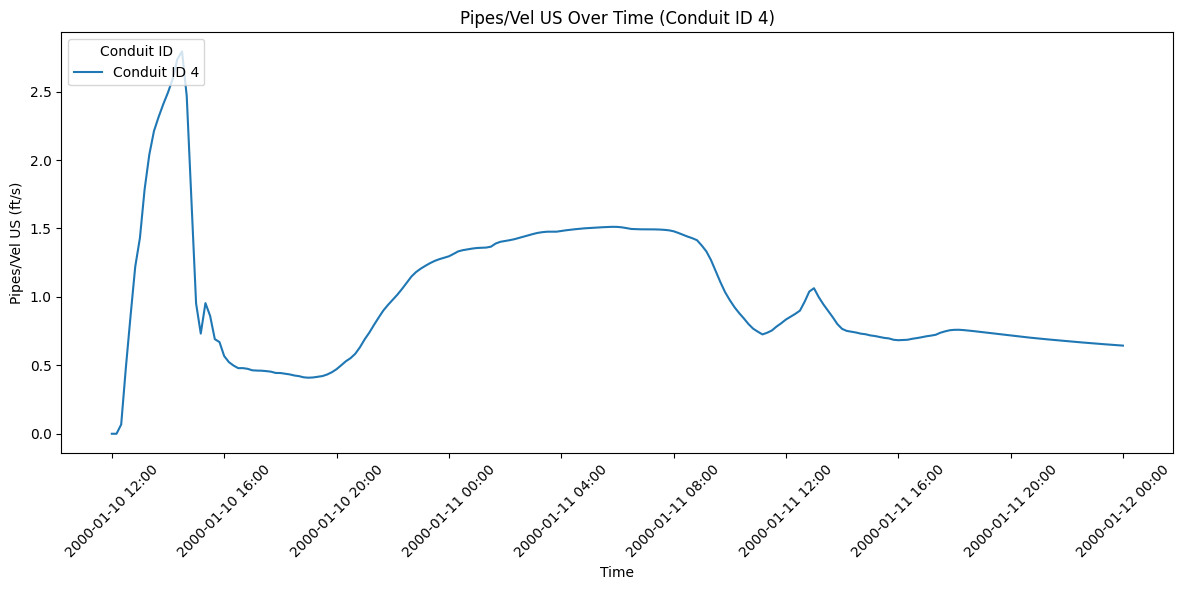

2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:53 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


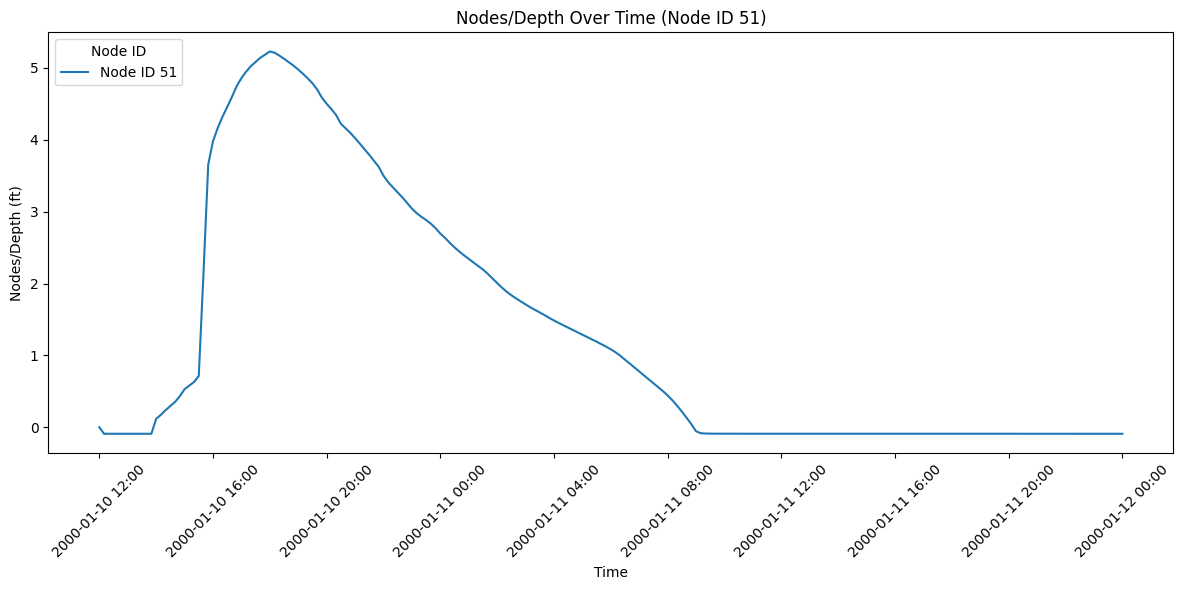

2025-03-27 22:56:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


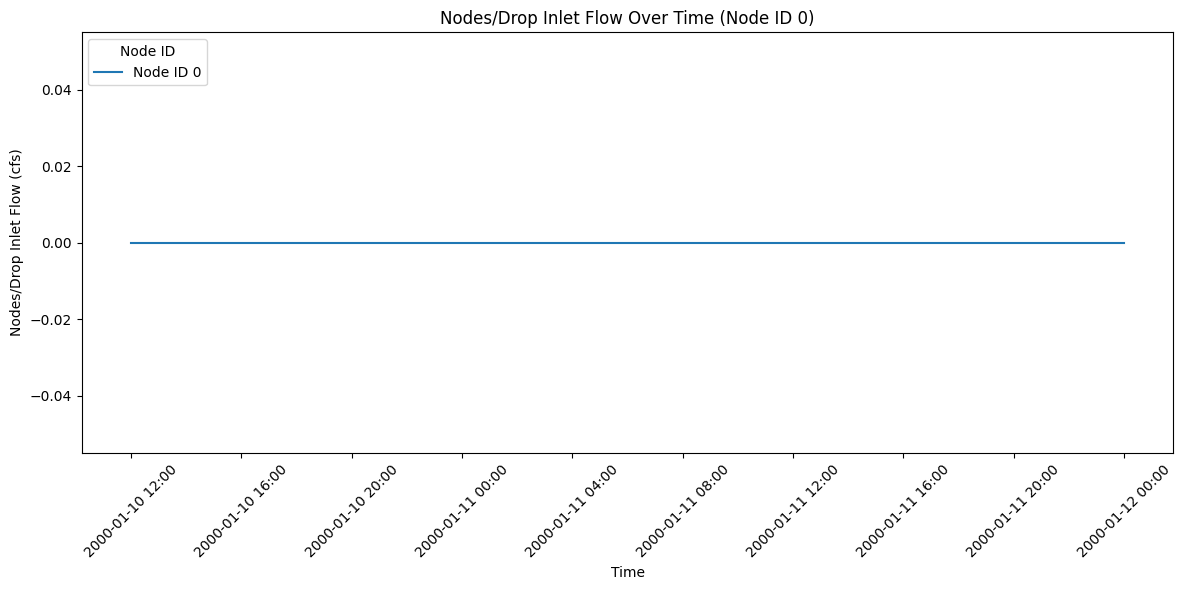

2025-03-27 22:56:54 - ras_commander.HdfPipe - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:54 - ras_commander.HdfPipe - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf


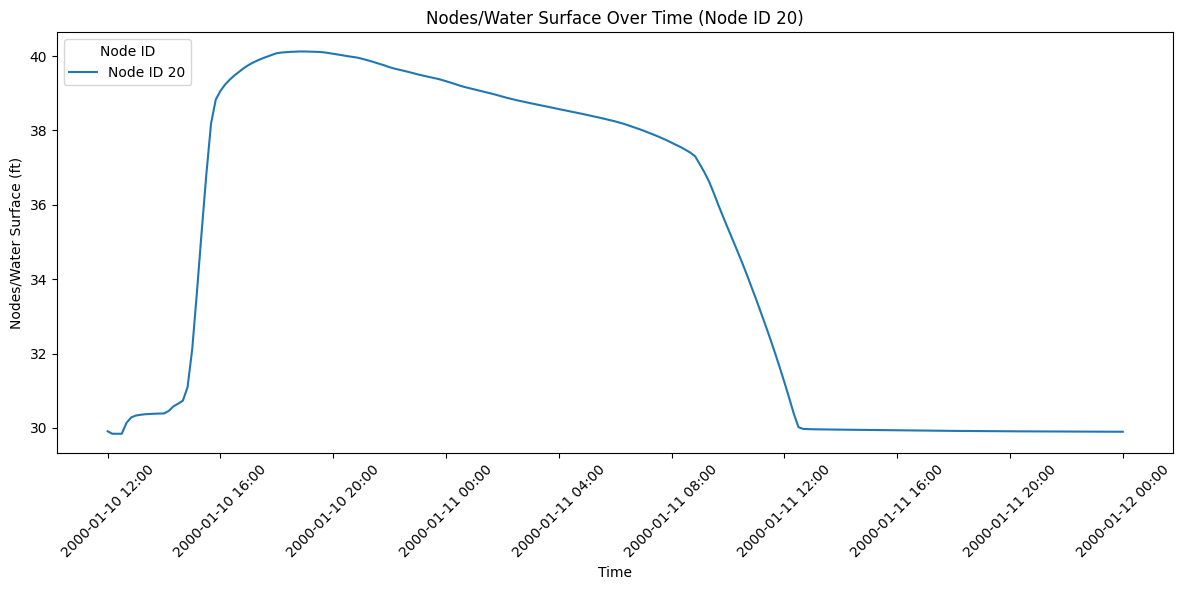

In [28]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import random

# Define the variables we want to plot
variables = [
    "Pipes/Pipe Flow DS", "Pipes/Pipe Flow US", "Pipes/Vel DS", "Pipes/Vel US",
    "Nodes/Depth", "Nodes/Drop Inlet Flow", "Nodes/Water Surface"
]

# Create a separate plot for each variable
for variable in variables:
    try:
        # Get the data for the current variable
        data = HdfPipe.get_pipe_network_timeseries(plan_hdf_path, variable=variable)
        
        # Create a new figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Pick one random location
        random_location = random.choice(data.location.values)
        
        # Determine if it's a pipe or node variable
        if variable.startswith("Pipes/"):
            location_type = "Conduit ID"
        else:
            location_type = "Node ID"
        
        # Plot the data for the randomly selected location
        ax.plot(data.time, data.sel(location=random_location), label=f'{location_type} {random_location}')
        
        # Set the title and labels
        ax.set_title(f'{variable} Over Time ({location_type} {random_location})')
        ax.set_xlabel('Time')  # Corrected from ax.xlabel to ax.set_xlabel
        ax.set_ylabel(f'{variable} ({data.attrs["units"]})')  # Corrected from ax.ylabel to ax.set_ylabel
        
        # Format the x-axis to show dates nicely
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=45)
        
        # Add a legend
        ax.legend(title=location_type, loc='upper left')
        
        # Adjust the layout
        plt.tight_layout()
        
        # Show the plot
        plt.show()
        
    except Exception as e:
        print(f"Error plotting {variable}: {str(e)}")


In [29]:
# Example 8: Get pump station timeseries
pump_station_name = pump_stations_gdf.iloc[0]['Name']  # Get the first pump station name
# Use the results_pump_station_timeseries method 
pump_timeseries = HdfPump.get_pump_station_timeseries(plan_hdf_path, pump_station=pump_station_name)
print(f"\nPump Station Timeseries ({pump_station_name}):")
print(pump_timeseries)

2025-03-27 22:56:54 - ras_commander.HdfPump - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:54 - ras_commander.HdfPump - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pump Station Timeseries (Pump Station #1):
<xarray.DataArray 'Pump Station #1' (time: 217, variable: 5)> Size: 4kB
array([[ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       [ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       [ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       ...,
       [29.879713 , 25.919964 , 40.726162 , 29.879713 ,  0.8800183],
       [ 0.       , 25.509436 , 40.71937  ,  0.       ,  0.       ],
       [ 0.       , 25.691196 , 40.623196 ,  0.       ,  0.       ]],
      shape=(217, 5), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * variable  (variable) <U12 240B 'Flow' 'Stage HW' ... 'Pumps on'
Attributes:
    units:         [[b'Flow' b'cfs']\n [b'Stage HW' b'ft']\n [b'Stage TW' b'f...
    pump_station:  Pump Station #1


In [30]:
# Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/Pump Stations/")

2025-03-27 22:56:54 - ras_commander.HdfBase - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:54 - ras_commander.HdfBase - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Exploring group: /Geometry/Pump Stations/


    Dataset: /Geometry/Pump Stations//Attributes
        Shape: (1,)
        Dtype: [('Name', 'S16'), ('Inlet River', 'S16'), ('Inlet Reach', 'S16'), ('Inlet RS', 'S8'), ('Inlet RS Distance', '<f4'), ('Inlet SA/2D', 'S16'), ('Inlet Pipe Node', 'S32'), ('Outlet River', 'S16'), ('Outlet Reach', 'S16'), ('Outlet RS', 'S8'), ('Outlet RS Distance', '<f4'), ('Outlet SA/2D', 'S16'), ('Outlet Pipe Node', 'S32'), ('Reference River', 'S16'), ('Reference Reach', 'S16'), ('Reference RS', 'S8'), ('Reference RS Distance', '<f4'), ('Reference SA/2D', 'S16'), ('Reference Point', 'S32'), ('Reference Pipe Node', 'S32'), ('Highest Pump Line Elevation', '<f4'), ('Pump Groups', '<i4')]

    Dataset: /Geometry/Pump Stations//Points
        Shape: (1, 2)
        Dtype: float64
    Attributes for /Geometry/Pump Stations//Points:
        Column: b'X,Y'
        Row: b'Points'

    Group: /Geometry/Pump Stations//Pump Groups
        Dataset: /Geometry/Pump Stations//P

2025-03-27 22:56:54 - ras_commander.HdfPump - INFO - Using HDF file from direct string path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf
2025-03-27 22:56:54 - ras_commander.HdfPump - INFO - Final validated HDF file path: c:\GH\ras-commander\examples\example_projects\Davis\DavisStormSystem.p02.hdf



Pump Station Timeseries (Pump Station #1):
<xarray.DataArray 'Pump Station #1' (time: 217, variable: 5)> Size: 4kB
array([[ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       [ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       [ 0.       , 24.6      , 38.888123 ,  0.       ,  0.       ],
       ...,
       [29.879713 , 25.919964 , 40.726162 , 29.879713 ,  0.8800183],
       [ 0.       , 25.509436 , 40.71937  ,  0.       ,  0.       ],
       [ 0.       , 25.691196 , 40.623196 ,  0.       ,  0.       ]],
      shape=(217, 5), dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 2kB 2000-01-10T12:00:00 ... 2000-01-12
  * variable  (variable) <U12 240B 'Flow' 'Stage HW' ... 'Pumps on'
Attributes:
    units:         [[b'Flow' b'cfs']\n [b'Stage HW' b'ft']\n [b'Stage TW' b'f...
    pump_station:  Pump Station #1


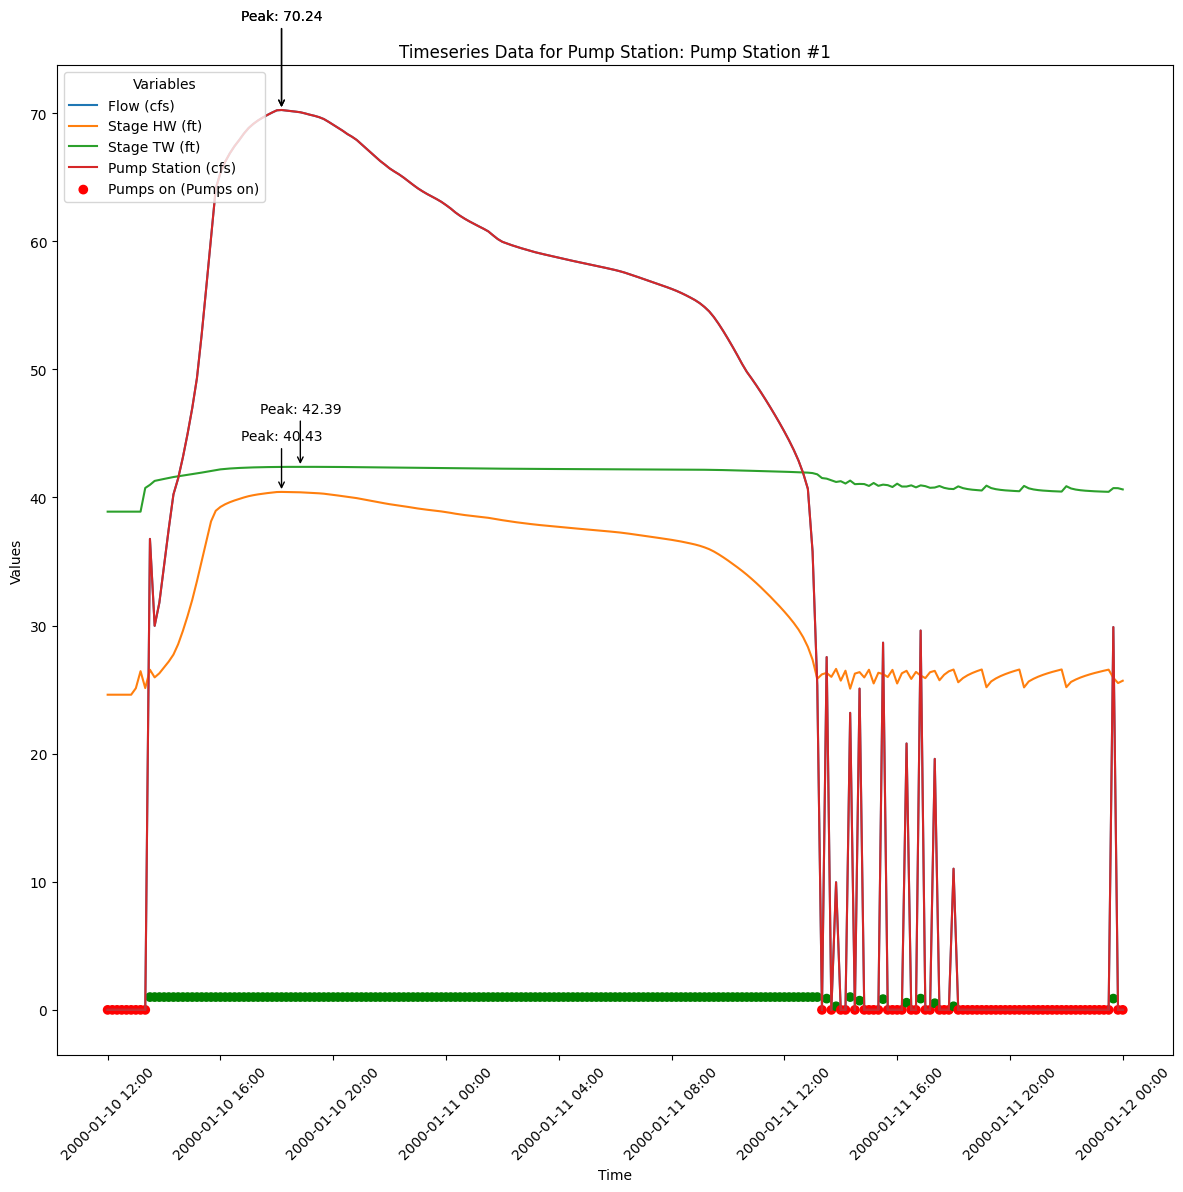

In [31]:
# Extract the pump station timeseries data
pump_station_name = pump_stations_gdf.iloc[0]['Name']  # Get the first pump station name
pump_timeseries = HdfPump.get_pump_station_timeseries(plan_hdf_path, pump_station=pump_station_name)

# Print the pump station timeseries
print(f"\nPump Station Timeseries ({pump_station_name}):")
print(pump_timeseries)

# Create a new figure for plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot each variable in the timeseries
for variable in pump_timeseries.coords['variable'].values:
    data = pump_timeseries.sel(variable=variable)
    
    # Decode units to strings
    unit = pump_timeseries.attrs["units"][list(pump_timeseries.coords["variable"].values).index(variable)][1].decode('utf-8')
    
    # Check if the variable is 'Pumps on' to plot it differently
    if variable == 'Pumps on':
        # Plot with color based on the on/off status
        colors = ['green' if val > 0 else 'red' for val in data.values.flatten()]
        ax.scatter(pump_timeseries['time'], data, label=f'{variable} ({unit})', color=colors)
    else:
        ax.plot(pump_timeseries['time'], data, label=f'{variable} ({unit})')
        
        # Label the peak values
        peak_time = pump_timeseries['time'][data.argmax()]
        peak_value = data.max()
        ax.annotate(f'Peak: {peak_value:.2f}', xy=(peak_time, peak_value), 
                    xytext=(peak_time, peak_value + 0.1 * peak_value), 
                    arrowprops=dict(facecolor='black', arrowstyle='->'),
                    fontsize=10, color='black', ha='center')

# Set the title and labels
ax.set_title(f'Timeseries Data for Pump Station: {pump_station_name}')
ax.set_xlabel('Time')
ax.set_ylabel('Values')

# Format the x-axis to show dates nicely
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

# Add a legend
ax.legend(title='Variables', loc='upper left')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## Exploring HDF Datasets with HdfBase.get_dataset_info
This allows users to find HDF information that is not included in the ras-commander library.  Find the path in HDFView and set the group_path below to explore the HDF datasets and attributes.  Then, use the output to write your own function to extract the data.  

#### Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/Pipe Conduits/")

For HDF datasets that are not supported by the RAS-Commander library, provide the dataset path to HdfBase.get_dataset_info and provide the output to an LLM along with a relevent HDF* class(es) to generate new functions that extend the library's coverage.   